# 0.データ読み込み

全解析で共通のデータフレームをここで読み込む。  
このDFを基本とし各解析ごとに不要な列の削除やdropを行うが、そのDropは次の解析には持ち越さず。毎回やり直す。

異常値の処理についても、上記の対応に同じ。各解析の中で異常値の行を落としても、他の解析で同行の異なる列のデータを利用する場合もあるので、全体には影響させないようにする。

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression



In [33]:
soil_data = pd.read_excel('/workspaces/akita_daizu/data/修正_土壌データ+収量.xlsx', header=0)

In [28]:
# dropコード例 土壌コードの省略
# drop_columns = soil_data.filter(like='土壌硬度', axis=1).columns.values
# soil_data.drop(drop_columns, axis = 1 ,inplace = True)

# 1.現場計測値と実験室計測値の相関分析

## 1-1簡易測定ph 実験室測定ph

Phは現場測定値と実験室の値が比較的近い

<AxesSubplot:xlabel='現場測定_PH', ylabel='実験室測定_pH'>

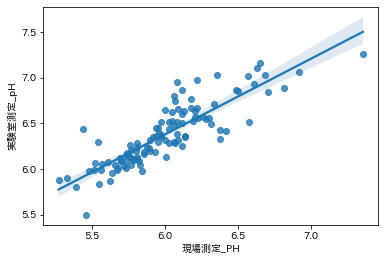

In [6]:
# 異常値取り除く
ph_soil = soil_data.drop(soil_data[soil_data['実験室測定_pH']>1000].index)
sns.regplot(x='現場測定_PH',y='実験室測定_pH',data=ph_soil)


In [7]:
x = ph_soil[['現場測定_PH']]
y = ph_soil[['実験室測定_pH']]
model_lr = LinearRegression()
model_lr.fit(x, y)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

y= 0.826x + 1.423
決定係数 R^2：  0.744282650456441


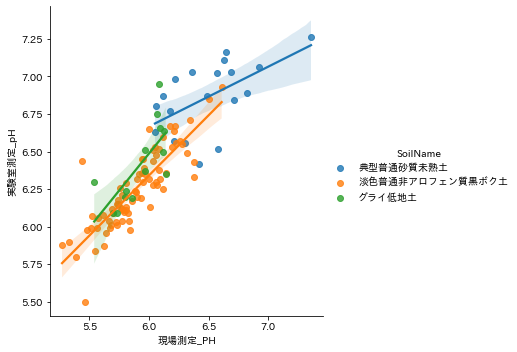

In [8]:
sns.lmplot(x='現場測定_PH',y='実験室測定_pH',hue = 'SoilName',data = ph_soil)

## 1-2 簡易測定EC 実験室測定EC

<AxesSubplot:xlabel='現場測定_EC', ylabel='実験室測定_EC (㎳／㎝)'>

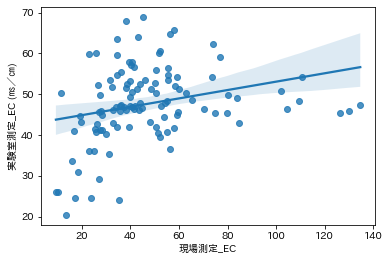

In [9]:
sns.regplot(x='現場測定_EC',y='実験室測定_EC (㎳／㎝)',data=soil_data)

In [10]:
x = ph_soil[['現場測定_EC']]
y = ph_soil[['実験室測定_EC (㎳／㎝)']]
model_lr = LinearRegression()
model_lr.fit(x, y)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

y= 0.103x + 42.825
決定係数 R^2：  0.07274036083856361


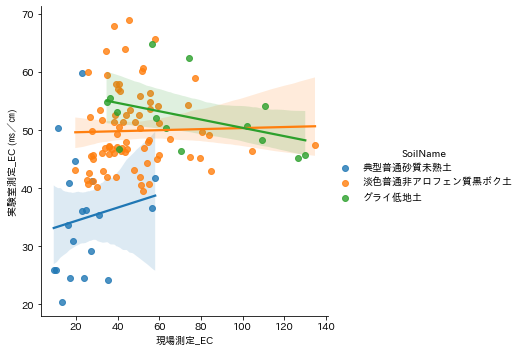

In [11]:
sns.lmplot(x='現場測定_EC',y='実験室測定_EC (㎳／㎝)',hue = 'SoilName',data = soil_data)

ECは現場計測で値が100以上のものを外れ値として外せないか？ 箱書いて検討

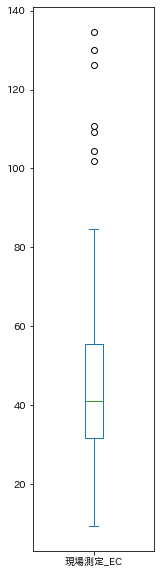

In [12]:
from date_analysis import get_box
get_box(soil_data ,['現場測定_EC'] )
# df 表示しないようにしたい

In [13]:
from date_analysis import box_Outlier
box_Outlier(soil_data ,['現場測定_EC'] )

現場測定_EC
Q1は：31.5025
Q3は：55.415
IQRは：23.912499999999998
外れ値は↓
60     134.67
71     110.67
72     130.00
73     109.33
74     102.00
82     104.33
100    126.33
Name: 現場測定_EC, dtype: float64
*********************


In [14]:
# 上記の結果より100以上を外れ値として処理すると
ec_soil = soil_data.drop(soil_data[soil_data['現場測定_EC']>100].index)

In [15]:
x = ec_soil[['現場測定_EC']]
y = ec_soil[['実験室測定_EC (㎳／㎝)']]
model_lr = LinearRegression()
model_lr.fit(x, y)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

y= 0.225x + 38.102
決定係数 R^2：  0.15520753718795421


<AxesSubplot:xlabel='現場測定_EC', ylabel='実験室測定_EC (㎳／㎝)'>

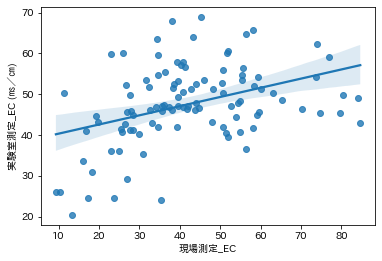

In [16]:
sns.regplot(x='現場測定_EC',y='実験室測定_EC (㎳／㎝)',data=ec_soil)

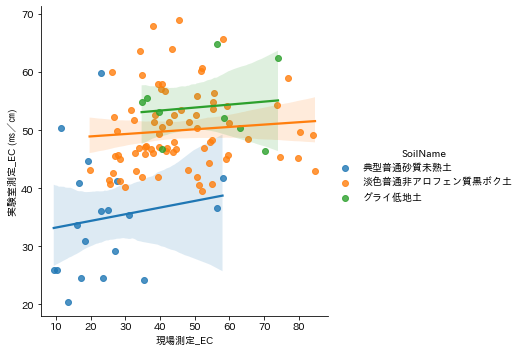

In [17]:
sns.lmplot(x='現場測定_EC',y='実験室測定_EC (㎳／㎝)',hue = 'SoilName',data = ec_soil )

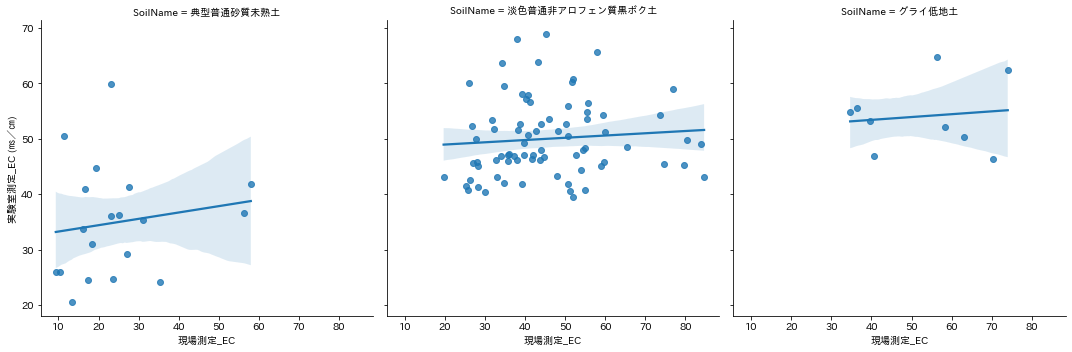

In [18]:
sns.lmplot(x='現場測定_EC',y='実験室測定_EC (㎳／㎝)',col = 'SoilName',data = ec_soil )


## 1-3 ECPHとTCTNの関係

In [ ]:
# heatmap作成のため不要な行の削除
drop_columns = soil_data.filter(like='土壌硬度', axis=1).columns.values
# droped_soil_data soil_data.drop(drop_columns, axis = 1 ,inplace = True)

In [29]:
# ex ph 共に異常値を取り除く
soil_data_wo_error = soil_data.drop(soil_data[soil_data['実験室測定_pH']>1000].index)
soil_data_wo_error = soil_data_wo_error.drop(soil_data_wo_error[soil_data_wo_error['現場測定_EC']>100].index)


In [30]:
corr = soil_data_wo_error.corr()
corr

,圃場番号,現場測定_EC,現場測定_PH,Spring[N/48.5mm],3データの最大圧の深さの平均,3データの最大圧力の平均,現物重量ｋｇ,計量時水分％,圃場面積,反収現物重量kg/10a,...,15%反収現物重量kg/10a,実験室測定_EC (㎳／㎝),実験室測定_pH,アンモニア態窒素 (mg N/100g),硝酸態窒素 (mg N/100g),可給隊窒素 (mg N/100g),有効態リン酸 (mg P2O5/100g),TC (%),腐食,TN (%)
圃場番号,1.000000,0.234583,-0.490030,NaN,0.151347,-0.412938,-0.203643,0.303288,-0.288406,0.028945,...,0.014970,0.511492,-0.561315,-0.142908,0.171449,0.515947,0.276296,0.552804,0.552838,0.576995
現場測定_EC,0.234583,1.000000,-0.229278,NaN,0.212803,-0.482555,-0.350592,0.349357,-0.382709,-0.065922,...,-0.082638,0.393964,-0.163362,0.130548,0.464651,0.347321,0.462241,0.193045,0.192926,0.292948
現場測定_PH,-0.490030,-0.229278,1.000000,NaN,-0.345677,0.446201,0.534523,-0.065589,0.286798,0.400617,...,0.408559,-0.478270,0.892088,-0.031425,-0.308682,-0.476732,-0.125204,-0.611654,-0.611563,-0.642926
Spring[N/48.5mm],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3データの最大圧の深さの平均,0.151347,0.212803,-0.345677,NaN,1.000000,-0.269308,-0.369845,0.021478,-0.307442,-0.128007,...,-0.135137,0.223086,-0.310434,0.054682,0.221486,0.235878,0.254259,0.401702,0.401754,0.411949
3データの最大圧力の平均,-0.412938,-0.482555,0.446201,NaN,-0.269308,1.000000,0.561723,-0.317320,0.630411,0.080811,...,0.099261,-0.505675,0.525252,-0.039234,-0.448617,-0.348611,-0.366257,-0.589247,-0.589297,-0.644120
現物重量ｋｇ,-0.203643,-0.350592,0.534523,NaN,-0.369845,0.561723,1.000000,-0.118969,0.622017,0.675664,...,0.684395,-0.355781,0.544463,-0.285009,-0.284007,-0.442881,-0.176501,-0.616619,-0.616664,-0.696163
計量時水分％,0.303288,0.349357,-0.065589,NaN,0.021478,-0.317320,-0.118969,1.000000,-0.140324,0.045908,...,0.011331,0.088056,-0.127915,0.143495,0.230763,-0.112934,-0.021920,0.011930,0.011587,0.062065
圃場面積,-0.288406,-0.382709,0.286798,NaN,-0.307442,0.630411,0.622017,-0.140324,1.000000,-0.120541,...,-0.110826,-0.505634,0.397667,-0.474844,-0.434089,-0.297029,-0.223675,-0.366502,-0.366541,-0.484969
反収現物重量kg/10a,0.028945,-0.065922,0.400617,NaN,-0.128007,0.080811,0.675664,0.045908,-0.120541,1.000000,...,0.999171,0.088290,0.268561,0.133637,0.087238,-0.279615,0.016773,-0.360003,-0.359979,-0.357916


<AxesSubplot:>

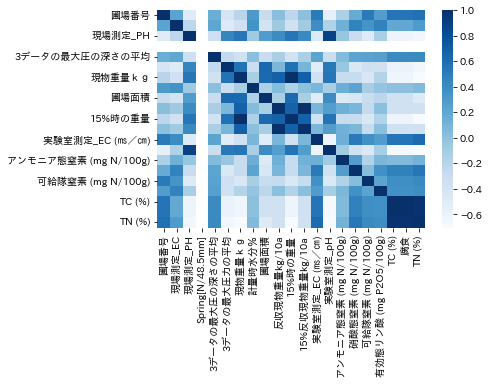

In [31]:
sns.heatmap(corr, cmap='Blues')

In [ ]:
flights = flights.pivot("month", "year", "passengers")
heatmap = sns.heatmap(flights)

# 2.収量と各パラメータの相関分析

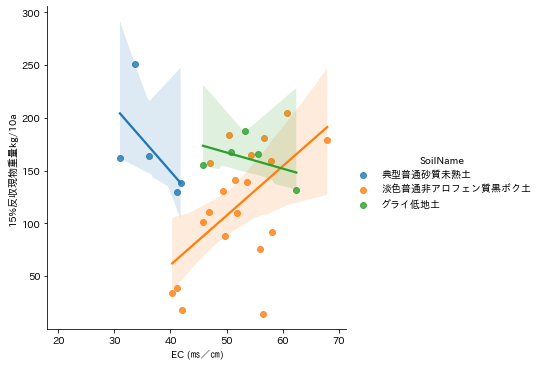

In [99]:
sns.lmplot(x='EC (㎳／㎝)',y='15%反収現物重量kg/10a',hue = 'SoilName',data = merge_df)

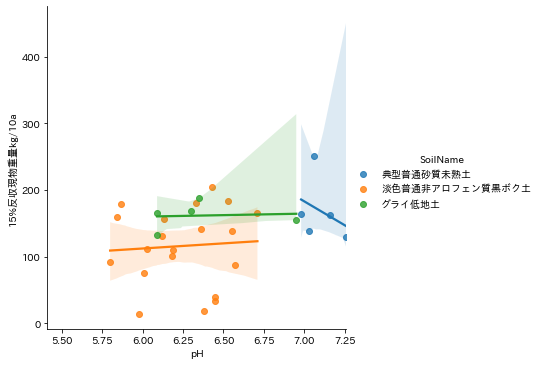

In [100]:
sns.lmplot(x='pH',y='15%反収現物重量kg/10a',data = merge_df,hue='SoilName')

In [101]:
vv_wave = pd.read_excel('VV_VH_2021_Gifu.xlsx')

In [102]:
vv_wave.head(300)

,GPS,y,x,Time,index,Sat,Direction,VH,VV,SM (%),Stagnant Water
0,1,35.23906,136.66388,25/06/2021 12:31:51,20210625T085802_20210625T085835,S1B_IW_G,Ascending,-15.635729,-9.577485,37.600000,0.0
1,2,35.23901,136.66322,25/06/2021 12:33:37,20210625T085802_20210625T085835,S1B_IW_G,Ascending,-17.337189,-9.425779,37.116667,0.0
2,3,35.23883,136.66290,25/06/2021 12:35:43,20210625T085802_20210625T085835,S1B_IW_G,Ascending,-16.938765,-9.807066,33.657143,0.0
3,4,35.23891,136.66251,25/06/2021 12:37:13,20210625T085802_20210625T085835,S1B_IW_G,Ascending,-18.266301,-7.341603,43.320000,0.0
4,5,35.23886,136.66197,25/06/2021 12:38:34,20210625T085802_20210625T085835,S1B_IW_G,Ascending,-15.639117,-6.489778,44.600000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
221,g20,35.25172,136.59149,13/07/2021 15:36:39,20210713T210005_20210713T210030,S1A_IW_G,Descending,-13.340418,-5.965924,40.440000,0.0
222,g21,35.25148,136.59090,13/07/2021 15:38:29,20210713T210005_20210713T210030,S1A_IW_G,Descending,-13.391045,-13.120848,35.428571,0.0
223,g22,35.25122,136.59010,13/07/2021 15:40:49,20210713T210005_20210713T210030,S1A_IW_G,Descending,-13.137863,-10.904257,32.366667,0.0
224,g23,35.25096,136.59043,13/07/2021 15:42:01,20210713T210005_20210713T210030,S1A_IW_G,Descending,-20.680746,-8.029115,32.657143,0.0


In [103]:
vv_wave = vv_wave.dropna()

In [104]:
from sklearn.linear_model import LinearRegression

features = ['VV']
X = vv_wave[features]
y= vv_wave['SM (%)']

reg = LinearRegression()
reg.fit(X,y)

b=reg.coef_
a=reg.intercept_

print("b={}".format(reg.coef_))
print("a={}".format(reg.intercept_))


b=[2.78638503]
a=61.130183470389355


回帰係数b,切片a
$$y=bx+a$$

Text(0, 0.5, 'SM(%)')

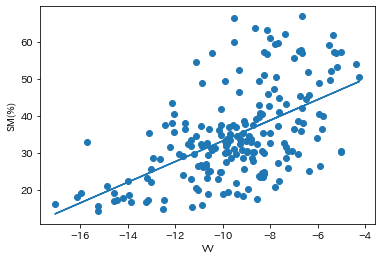

In [105]:
plt.plot(X,b*X+a)
plt.scatter(X,y)
plt.xlabel('VV')
plt.ylabel('SM(%)')

In [106]:
ftir_df = pd.read_excel('FTIR_TC_TN.xlsx')

In [107]:
ftir_df.head()

,id,TC,TN
0,1.0,1.710324,0.118744
1,2.0,0.333871,0.080190
2,3.0,0.463173,0.108942
3,4.0,0.644118,0.119717
4,5.0,2.106233,0.157006


In [108]:
ftir_df.rename(columns={'id':'圃場番号'},inplace=True)

In [109]:
ftir_df.head()

,圃場番号,TC,TN
0,1.0,1.710324,0.118744
1,2.0,0.333871,0.080190
2,3.0,0.463173,0.108942
3,4.0,0.644118,0.119717
4,5.0,2.106233,0.157006


In [110]:
merge_df = pd.merge(merge_df,ftir_df, on='圃場番号', how = 'left')

In [111]:
merge_df.head()

,圃場番号,附番,EC,PH,硬度計ID,Latitude,Longitude,Set Depth[cm],Date and Time,Cone[cm2],...,計量時水分％,圃場面積,住所,反収現物重量kg/10a,15%時の重量,15%反収現物重量kg/10a,EC (㎳／㎝),pH,TC,TN
0,1.0,2,25,7.14,A2,N 40.268380,E 140.022773,60,21.11.04 08:38:48,2,...,0.180,5387.0,沼田横長根下1-4,134.0,700.0,130.0,41.2,7.26,1.710324,0.118744
1,2.0,2,17,6.78,2,N 00.00.0000,E 000.00.0000,60,21.11.04 08:51:30,2,...,NaN,NaN,NaN,NaN,NaN,NaN,35.4,6.42,0.333871,0.080190
2,3.0,2,20,6.50,5,N 00.00.0000,E 000.00.0000,60,21.11.04 08:59:48,2,...,NaN,NaN,NaN,NaN,NaN,NaN,29.2,6.56,0.463173,0.108942
3,4.0,2,8,6.63,8,N 00.00.0000,E 000.00.0000,60,21.11.04 09:07:24,2,...,NaN,NaN,NaN,NaN,NaN,NaN,24.5,6.87,0.644118,0.119717
4,5.0,2,43,6.68,11,N 00.00.0000,E 000.00.0000,60,21.11.04 09:13:31,2,...,0.183,5643.0,沼田坊塚下1-4,144.0,780.0,138.0,41.8,7.03,2.106233,0.157006


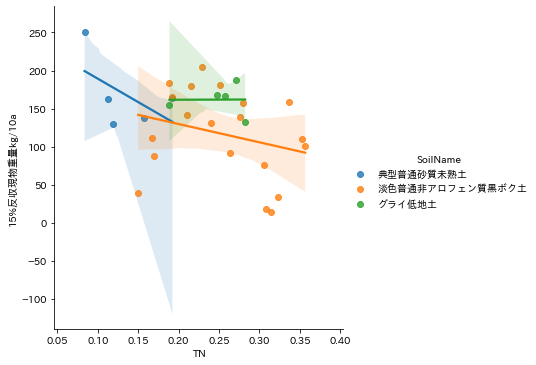

In [112]:
sns.lmplot(x='TN',y='15%反収現物重量kg/10a',data = merge_df,hue='SoilName')

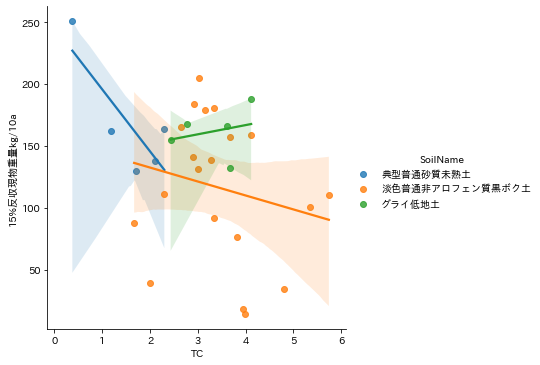

In [113]:
sns.lmplot(x='TC',y='15%反収現物重量kg/10a',data = merge_df,hue='SoilName')

In [114]:
merge_df.rename(columns={'TC':'FTIR_TC','TN':'FTIR_TN','EC (㎳／㎝)':'EC (㎳／㎝)_実験室','pH':'pH_実験室'},inplace=True)

In [115]:
#merge_df.to_csv('merge_df.csv',index = False)
#merge_df.to_csv('merge_df_mac.csv',index= False,encoding='utf_8_sig')